In [2]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Path to the .mseed file
data_directory = '../../data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-01-09HR00_evid00007.mseed'
mseed_file = f'{data_directory}'

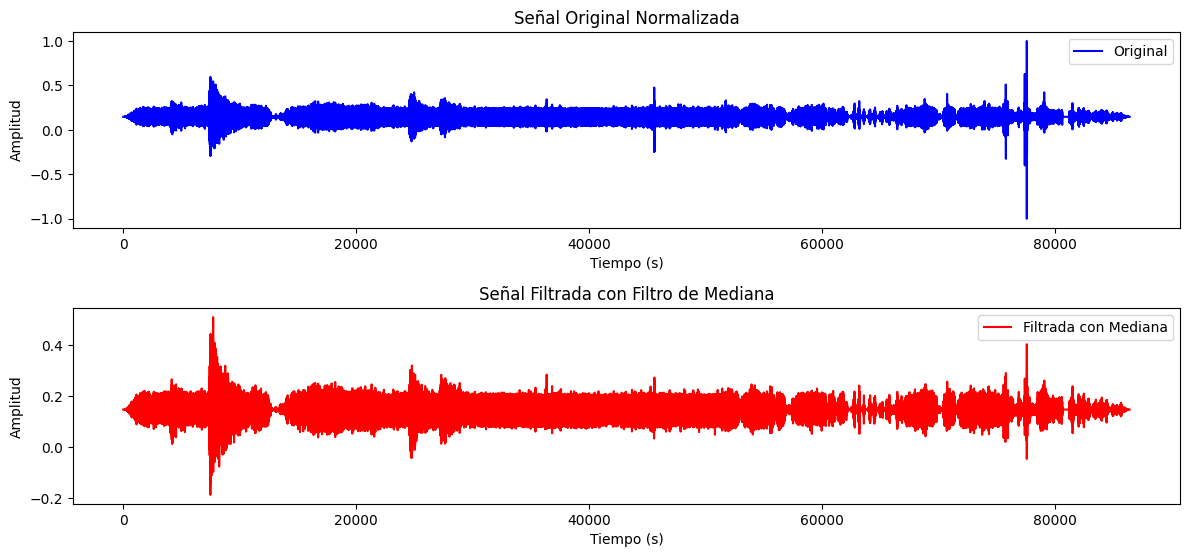

In [3]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Read the mseed file
st = read(mseed_file)
tr = st[0].copy()  # Obtain the first trace

# Apply a bandpass filter
minfreq = 0.5
tr.filter('highpass', freq=minfreq)

# Obtain filtered trace data
tr_times = tr.times()
tr_data = tr.data

# Min-Max normalization
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Scaling between -1 and 1

# 1. Apply a Median Filter
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5) 

# Visualize the signals
plt.figure(figsize=(12, 8))

# Original signal
plt.subplot(3, 1, 1)
plt.plot(tr_times, tr_data_minmax, 'b-', label='Original')
plt.title('Señal Original Normalizada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Filtered Signal with Median
plt.subplot(3, 1, 2)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

[array([49677, 53600], dtype=int64)]


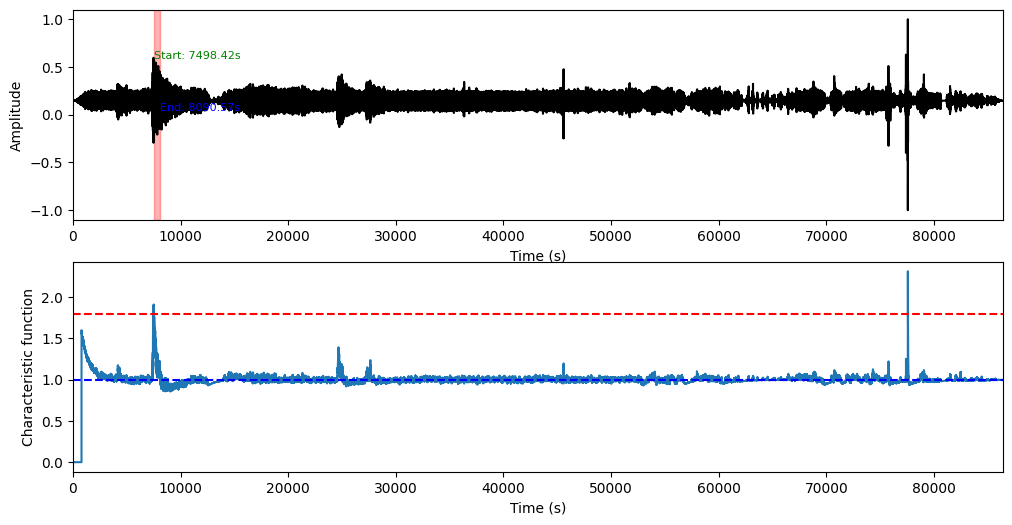

In [4]:
from obspy.signal.trigger import recursive_sta_lta, trigger_onset
import matplotlib.pyplot as plt
import numpy as np
l_threshold_on = [8,4,2,1.8,1.5,1.3,1.15]
l_threshold_off = [2,2,1,1,1,1,0]
merged_on_off = []
x,y = 0,0
while merged_on_off == []:
    df = tr.stats.sampling_rate
    # Apply a bandpass filter before the analysis
    tr.filter('highpass', freq=minfreq)  # Adjust the bandpass filter

    # STA/LTA window lengths in seconds
    sta_len = 20#60  # Short-term window
    lta_len = 800#1800  # Long-term window

    # Execute recursive STA/LTA
    cft = recursive_sta_lta( tr_data_minmax, int(sta_len * df), int(lta_len * df))

    cft_smoothed = medfilt(cft, kernel_size=5)

    # Define thresholds for detection (adjusted)
    threshold_on = l_threshold_on[x] # Increase the activation threshold
    threshold_off = l_threshold_off[y] # Increase the deactivation threshold

    # Detect events
    on_off = trigger_onset(cft_smoothed, threshold_on, threshold_off)

    # Filter short detections (less than 60 seconds)
    min_duration = 360 * df
    on_off_filtered = [event for event in on_off if (event[1] - event[0]) > min_duration]

    # Merge close detections (if the difference between them is less than a certain time)
    min_gap = 5000  # Number of samples between detected events to merge them
    merged_on_off = []
    if len(on_off_filtered) > 0:
        current_event = on_off_filtered[0]
        for i in range(1, len(on_off_filtered)):
            if on_off_filtered[i][0] - current_event[1] < min_gap:
                current_event[1] = on_off_filtered[i][1]  # Merge events
            else:
                merged_on_off.append(current_event)
                current_event = on_off_filtered[i]
        merged_on_off.append(current_event)
    x+=1
    y+=1
# Visualize the characteristic function and the detections
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Signal plot with detections
ax[0].plot(tr.times(),  tr_data_minmax, 'k')  # Use the normalized signal
for start, end in merged_on_off:
    # Convert indeces to time in seconds
    start_time = start / df
    end_time = end / df
    
    # Highlight the detected interval
    ax[0].axvspan(tr.times()[start], tr.times()[end], color='red', alpha=0.3)
    
    # Record the start and end time
    ax[0].text(tr.times()[start],  tr_data_minmax[start], f'Start: {start_time:.2f}s', color='green', fontsize=8, verticalalignment='bottom')
    ax[0].text(tr.times()[end],  tr_data_minmax[end], f'End: {end_time:.2f}s', color='blue', fontsize=8, verticalalignment='top')

ax[0].set_xlim([min(tr.times()), max(tr.times())])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

# Plot of the STA/LTA characteristic function
ax[1].plot(tr.times(), cft_smoothed)
ax[1].axhline(y=threshold_on, color='r', linestyle='--')
ax[1].axhline(y=threshold_off, color='b', linestyle='--')
ax[1].set_xlim([min(tr.times()), max(tr.times())])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Characteristic function')
print(merged_on_off)


plt.show()

In [7]:
i=0

for start_test,end_test in merged_on_off:
    i+=1
    print(f'{i}. Event detected at {start_test/df} s - {end_test/df} s')

time_start_event = int(start_test/df)
time_end_event = int(end_test/df)
print(time_start_event)
print(time_end_event)

7498
8090


In [8]:
merged_on_off

[array([49677, 53600], dtype=int64)]

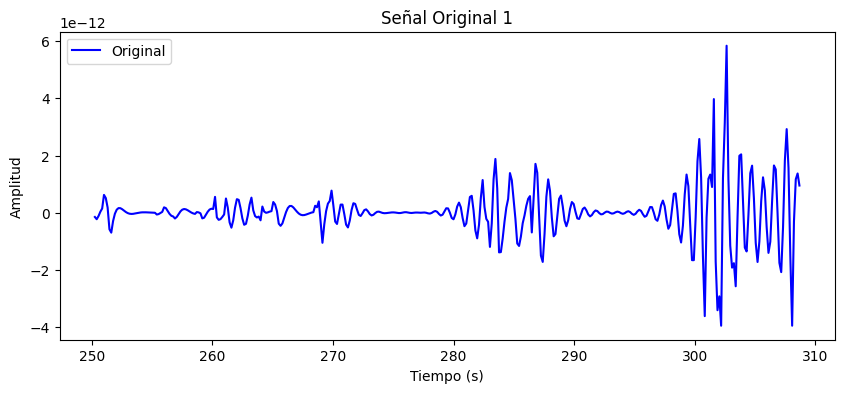

In [8]:
i = 0

for start_test, end_test in merged_on_off:
    # Create a new figure for each signal
    plt.figure(figsize=(10, 4))
    
    # Original signal
    plt.plot(tr_times[int(start_test/df):int(end_test/df)], 
            tr_data[int(start_test/df):int(end_test/df)], 
            'b-', label='Original')
    
    plt.title(f'Señal Original {i+1}')  # Title with signal number
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.legend()
    # Show the plot
    plt.show()
    